## Overview

The purpose of this notebook is to analyze the dataset of E coli, before applying sequence clustering.

## Imports

In [1]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    get_clusters,
    corr_heatmap,
    plot_full_test,
    pca_plot_2d,
    pca_plot_3d,
)
from subpred.eval import quick_test, models_quick_compare, full_test


## Creating the dataset

In [2]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "keep",
    verbose = True,
    tax_ids_filter = [83333],
    output_log = "../logs/athaliana_amino_sugar_dataset.log",
)

In [3]:
df.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P69801,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,manY pel ptsP b1818 JW1807,PTS system mannose-specific EIIC component (EI...,4.A.6.1.1,4.A,83333,MEITTLQIVLVFIVACIAGMGSILDEFQFHRPLIACTLVGIVLGDM...
P36672,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,treB b4240 JW4199,PTS system trehalose-specific EIIBC component ...,4.A.1.2.4,4.A,83333,MMSKINQTDIDRLIELVGGRGNIATVSHCITRLRFVLNQPANARPK...
P56580,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,srlE gutA gutE b2703 JW5430,PTS system glucitol/sorbitol-specific EIIB com...,4.A.4.1.1,4.A,83333,MTHIRIEKGTGGWGGPLELKATPGKKIVYITAGTRPAIVDKLAQLT...
P0AA47,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,plaP yeeF b2014 JW5330,Low-affinity putrescine importer PlaP,2.A.3.1.14,2.A,83333,MSHNVTPNTSRVELRKTLTLVPVVMMGLAYMQPMTLFDTFGIVSGL...
P08722,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,bglF bglC bglS b3722 JW3700,PTS system beta-glucoside-specific EIIBCA comp...,4.A.1.2.2,4.A,83333,MTELARKIVAGVGGADNIVSLMHCATRLRFKLKDESKAQAEVLKKT...


### Stats

The dataset is just barely imbalanced, but also contains transporters that are annotated with multiple substrates. Those seem to be mostly ion antiporters and symporters.

In [4]:
df.keywords_transport.value_counts()

Amino-acid transport                                      50
Sugar transport                                           47
Ion transport;Sugar transport                              4
Amino-acid transport;Ion transport;Sodium transport        2
Ion transport;Polysaccharide transport;Sugar transport     1
Phosphate transport;Sugar transport                        1
Name: keywords_transport, dtype: int64

Most proteins are located in the inner cell membrane, which typically has similarities to eukaryotes in terms of membrane proteins. The outer membrane proteins might be worth taking a look at.

In [5]:
df.keywords_location.value_counts()

Cell inner membrane;Cell membrane;Membrane;Transmembrane    99
Cell outer membrane;Membrane;Transmembrane                   5
Cell membrane;Membrane;Transmembrane                         1
Name: keywords_location, dtype: int64

What is the single protein that is not annotated with "Cell inner membrane"?

In [6]:
df[df.keywords_location == "Cell membrane;Membrane;Transmembrane"]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P76249,Amino-acid transport,Cell membrane;Membrane;Transmembrane,Transport,leuE yeaS b1798 JW1787,Leucine efflux protein,2.A.76.1.5,2.A,83333,MFAEYGVLNYWTYLVGAIFIVLVPGPNTLFVLKNSVSSGMKGGYLA...


Nothing to worry about, it is a multi-pass membrane transporter. According to GO, it is located in the inner membrane. That information seems to be missing in Uniprot. What about the outer membrane proteins?

In [7]:
df[df.keywords_location.str.contains("Cell outer membrane")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P76773,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,ompL yshA b3875 JW3846,Porin OmpL,1.B.35.2.2,1.B,83333,MKKINAIILLSSLTSASVFAGAYVENREAYNLASDQGEVMLRVGYN...
Q47706,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,uidC gusC b1615 JW1607,Membrane-associated protein UidC,1.B.25.1.5,1.B,83333,MRKIVAMAVICLTAASGLTSAYAAQLADDEAGLRIRLKNELRRADK...
P02943,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,lamB malB b4036 JW3996,Maltoporin (Maltose outer membrane channel) (M...,1.B.3.1.1,1.B,83333,MMITLRKLPLAVAVAAGVMSAQAMAVDFHGYARSGIGWTGSGGEQQ...
P75733,Ion transport;Polysaccharide transport;Sugar t...,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,chiP ybfM b0681 JW0667,Chitoporin (ChiP-III),1.B.25.1.13,1.B,83333,MRTFSGKRSTLALAIAGVTAMSGFMAMPEARAEGFIDDSTLTGGIY...
P69856,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,nanC yjhA b4311 JW5778,Probable N-acetylneuraminic acid outer membran...,1.B.35.2.1,1.B,83333,MKKAKILSGVLLLCFSSPLISQAATLDVRGGYRSGSHAYETRLKVS...


Those are porins, and have a beta barrel structure according to Alphafold. Since barrel proteins are very different in terms of amino acid composition, it would probably be best to remove this small subset of proteins.

There are some symporters and antiporters in the dataset:

In [8]:
df.keywords_transport_related.value_counts()

Transport                     80
Symport;Transport             15
Porin;Transport                5
Antiport;Transport             4
Antiport;Symport;Transport     1
Name: keywords_transport_related, dtype: int64

After a first glance at the annotations and their Uniprot entries, nothing seems out of the ordinary. Maybe the sequences and the clustering show some differences later.

In [9]:
df[df.keywords_transport_related.str.contains("Antiport")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P0AAF1,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Antiport;Symport;Transport,potE b0692 JW0679,Putrescine transporter PotE (Putrescine-proton...,2.A.3.2.1,2.A,83333,MSQAKSNKMGVVQLTILTMVNMMGSGIIMLPTKLAEVGTISIISWL...
P60061,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Antiport;Transport,adiC aniC yjdD yjdE b4115 JW4076,Arginine/agmatine antiporter,2.A.3.2.5,2.A,83333,MSSDADAHKVGLIPVTLMVSGNIMGSGVFLLPANLASTGGIAIYGW...
P0AAE8,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Antiport;Transport,cadB b4132 JW4093,Probable cadaverine/lysine antiporter,2.A.3.2.2,2.A,83333,MSSAKKIGLFACTGVVAGNMMGSGIALLPANLASIGGIAIWGWIIS...
P0AAE5,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Antiport;Transport,ydgI b1605 JW1597,Putative arginine/ornithine antiporter,2.A.3.2.8,2.A,83333,MEKKLGLSALTALVLSSMLGAGVFSLPQNMAAVASPAALLIGWGIT...
P63235,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Antiport;Transport,gadC acsA xasA b1492 JW1487,Glutamate/gamma-aminobutyrate antiporter (Glu/...,NaN,0.0,83333,MATSVQTGKAKQLTLLGFFAITASMVMAVYEYPTFATSGFSLVFFL...


In [10]:
df[df.keywords_transport_related.str.contains("Symport")].head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P27125,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Symport;Transport,rhaT b3907 JW3878,L-rhamnose-proton symporter (L-rhamnose-H(+) t...,2.A.7.6.1,2.A,83333,MSNAITMGIFWHLIGAASAACFYAPFKKVKKWSWETMWSVGGIVSW...
P0AAF1,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Antiport;Symport;Transport,potE b0692 JW0679,Putrescine transporter PotE (Putrescine-proton...,2.A.3.2.1,2.A,83333,MSQAKSNKMGVVQLTILTMVNMMGSGIIMLPTKLAEVGTISIISWL...
P07117,Amino-acid transport;Ion transport;Sodium tran...,Cell inner membrane;Cell membrane;Membrane;Tra...,Symport;Transport,putP b1015 JW1001,Sodium/proline symporter (Proline permease) (P...,2.A.21.2.1,2.A,83333,MAISTPMLVTFCVYIFGMILIGFIAWRSTKNFDDYILGGRSLGPFV...
P0AGE4,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Symport;Transport,sstT ygjU b3089 JW3060,Serine/threonine transporter SstT (Na(+)/serin...,2.A.23.4.1,2.A,83333,MTTQRSPGLFRRLAHGSLVKQILVGLVLGILLAWISKPAAEAVGLL...
P0AGF4,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Symport;Transport,xylE b4031 JW3991,D-xylose-proton symporter (D-xylose transporter),2.A.1.1.3,2.A,83333,MNTQYNSSYIFSITLVATLGGLLFGYDTAVISGTVESLNTVFVAPQ...


#### TCDB

In contrast to A Thaliana, this dataset is almost completely annotated with TCDB identifiers. Also, there is a larger number of active transporters, and electron transporters. The five channels are the pores we found above.

We might have to be careful with the active transport proteins, they could also be parts of transport complexes that do not actually carry out the transport themselves

In [11]:
df.tcdb_class.value_counts()

2.A    55
3.A    23
4.A    17
0.0     5
1.B     5
Name: tcdb_class, dtype: int64

It might be easier to find peripheral membrane proteins through their sequences, by clustering the dataset.

In [12]:
df[df.tcdb_class.str.startswith("3")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P14176,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,proW b2678 JW2653,Glycine betaine/proline betaine transport syst...,3.A.1.12.1,3.A,83333,MADQNNPWDTTPAADSAAQSADAWGTPTTAPTDGGGADWLTSTPAP...
P0AGI4,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,xylH b3568 JW3540,Xylose transport system permease protein XylH,3.A.1.2.4,3.A,83333,MSKSNPSEVKLAVPTSGGFSGLKSLNLQVFVMIAAIIAIMLFFTWT...
P0AGI1,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,rbsC b3750 JW3729,Ribose import permease protein RbsC,3.A.1.2.1,3.A,83333,MTTQTVSGRRYFTKAWLMEQKSLIALLVLIAIVSTLSPNFFTINNL...
P52094,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,hisQ b2308 JW2305,Histidine transport system permease protein HisQ,3.A.1.3.29,3.A,83333,MLYGFSGVILQGALVTLELAISSVVLAVIIGLIGAGGKLSQNRLSG...
P68183,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,malG b4032 JW3992,Maltose/maltodextrin transport system permease...,3.A.1.1.1,3.A,83333,MAMVQPKSQKARLFITHLLLLLFIAAIMFPLLMVVAISLRQGNFAT...
P0AFT2,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,tcyL yecS b1918 JW1903,L-cystine transport system permease protein TcyL,3.A.1.3.10,3.A,83333,MQESIQLVIDSLPFLLKGAGYTLQLSIGGMFFGLLLGFILALMRLS...
P0AE26,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,araH b4460 JW1887,L-arabinose transport system permease protein ...,3.A.1.2.2,3.A,83333,MSSVSTSGSGAPKSSFSFGRIWDQYGMLVVFAVLFIACAIFVPNFA...
P0AER3,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,gltJ b0654 JW0649,Glutamate/aspartate import permease protein GltJ,3.A.1.3.4,3.A,83333,MSIDWNWGIFLQQAPFGNTTYLGWIWSGFQVTIALSICAWIIAFLV...
P0AE30,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,artM b0861 JW0845,Arginine ABC transporter permease protein ArtM,3.A.1.3.3,3.A,83333,MFEYLPELMKGLHTSLTLTVASLIVALILALIFTIILTLKTPVLVW...


What are the proteins without TCDB entry?

In [13]:
df[df.tcdb_class.str.startswith("0")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P42910,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,agaC yraE b3139 JW3108,N-acetylgalactosamine permease IIC component 1...,NaN,0.0,83333,MHEITLLQGLSLAALVFVLGIDFWLEALFLFRPIIVCTLTGAILGD...
P31452,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,glvC ptiC b3683 JW3660,Phosphotransferase IIC component GlvC (PTS sys...,NaN,0.0,83333,MLSQIQRFGGAMFTPVLLFPFAGIVVGLAILLQNPMFVGESLTDPN...
P64550,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,alaE ygaW b2670 JW2645,L-alanine exporter AlaE,NaN,0.0,83333,MFSPQSRLRHAVADTFAMVVYCSVVNMCIEVFLSGMSFEQSFYSRL...
P02921,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Symport;Transport,melB mel-4 b4120 JW4081,Melibiose carrier protein (Melibiose permease)...,NaN,0.0,83333,MSISMTTKLSYGFGAFGKDFAIGIVYMYLMYYYTDVVGLSVGLVGT...
P63235,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Antiport;Transport,gadC acsA xasA b1492 JW1487,Glutamate/gamma-aminobutyrate antiporter (Glu/...,NaN,0.0,83333,MATSVQTGKAKQLTLLGFFAITASMVMAVYEYPTFATSGFSLVFFL...


Judging by their names, they are all carriers.

## Feature generation

In [14]:
labels = df.keywords_transport.rename("label").copy()
df_aac = calculate_aac(sequences=df.sequence)
df_paac = calculate_paac(sequences=df.sequence)

The only transporters that stand out in the PCA plot are the beta-barrel channels 

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

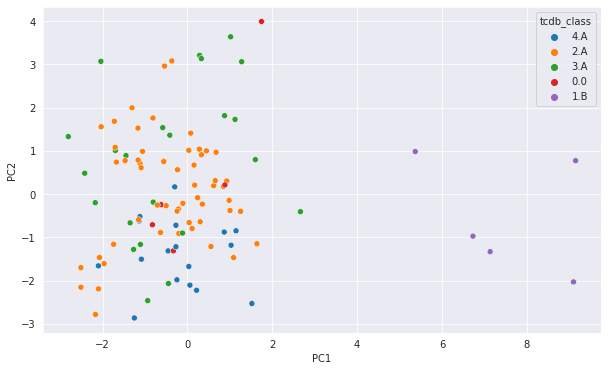

In [15]:
pca_plot_2d(df_aac, df.tcdb_class)

That is also the case in the clustermap. It doesn't look like peripheral membrane proteins that are parts of active transport complexes are in the dataset. This would not be the case if we would not have filtered the dataset for the keyword "Transmembrane" at the beginning of the notebook. In this case, this measure seems to take care of these types of outliers.

({'0.0': 'cyan',
  '1.B': 'magenta',
  '2.A': 'yellow',
  '3.A': 'green',
  '4.A': 'orange'},
 <seaborn.matrix.ClusterGrid at 0x7f5c72ea17c0>)

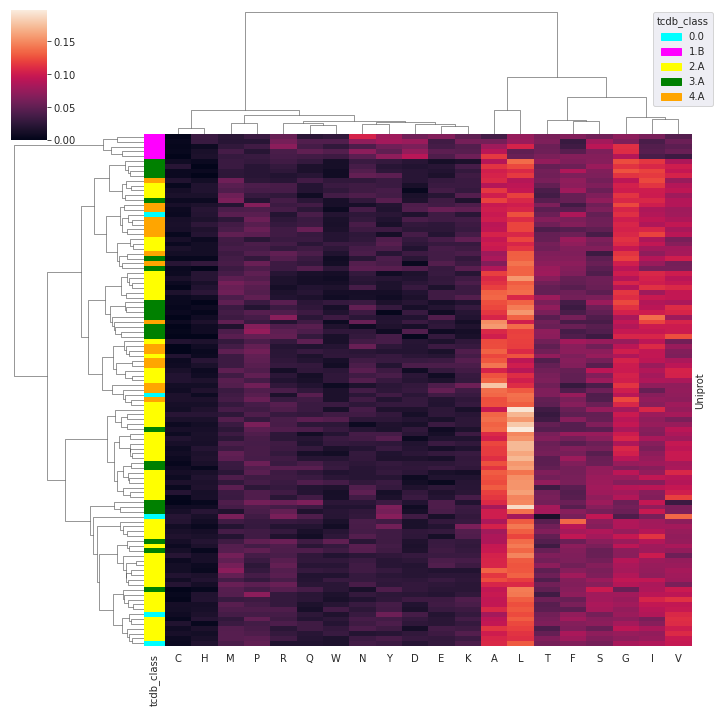

In [16]:
labeled_clustermap(df_aac, df.tcdb_class, xlabels="auto")

And in the pairwise correlation heatmap:

({'Cell inner membrane;Cell membrane;Membrane;Transmembrane': 'cyan',
  'Cell membrane;Membrane;Transmembrane': 'magenta',
  'Cell outer membrane;Membrane;Transmembrane': 'yellow'},
 <seaborn.matrix.ClusterGrid at 0x7f5bd248bcd0>)

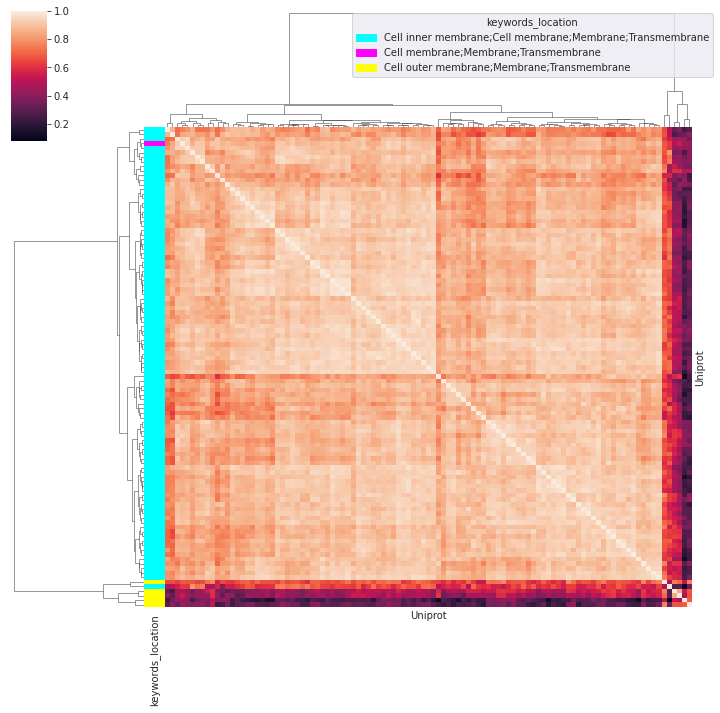

In [17]:
labeled_clustermap(df_aac.T.corr(), df.keywords_location)

There is one protein that clusters with the porins:

In [18]:
clusters = get_clusters(df_aac.T.corr(), n_clusters=2)
df.loc[clusters[0]]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P76773,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,ompL yshA b3875 JW3846,Porin OmpL,1.B.35.2.2,1.B,83333,MKKINAIILLSSLTSASVFAGAYVENREAYNLASDQGEVMLRVGYN...
Q47706,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,uidC gusC b1615 JW1607,Membrane-associated protein UidC,1.B.25.1.5,1.B,83333,MRKIVAMAVICLTAASGLTSAYAAQLADDEAGLRIRLKNELRRADK...
P64550,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,alaE ygaW b2670 JW2645,L-alanine exporter AlaE,NaN,0.0,83333,MFSPQSRLRHAVADTFAMVVYCSVVNMCIEVFLSGMSFEQSFYSRL...
P02943,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,lamB malB b4036 JW3996,Maltoporin (Maltose outer membrane channel) (M...,1.B.3.1.1,1.B,83333,MMITLRKLPLAVAVAAGVMSAQAMAVDFHGYARSGIGWTGSGGEQQ...
P75733,Ion transport;Polysaccharide transport;Sugar t...,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,chiP ybfM b0681 JW0667,Chitoporin (ChiP-III),1.B.25.1.13,1.B,83333,MRTFSGKRSTLALAIAGVTAMSGFMAMPEARAEGFIDDSTLTGGIY...
P69856,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,nanC yjhA b4311 JW5778,Probable N-acetylneuraminic acid outer membran...,1.B.35.2.1,1.B,83333,MKKAKILSGVLLLCFSSPLISQAATLDVRGGYRSGSHAYETRLKVS...


It has a Pearson correlation of 0.3-0.46 to three of the porins, however it looks like a alpha-helical bundle transporter. The correlation might just be chance. 

In [19]:
df_aac.loc[clusters[0]].T.corr().round(3)

Uniprot,P76773,Q47706,P64550,P02943,P75733,P69856
Uniprot,,,,,,
P76773,1.000,0.509,0.081,0.524,0.463,0.686
Q47706,0.509,1.000,0.466,0.756,0.709,0.759
P64550,0.081,0.466,1.000,0.294,0.305,0.336
P02943,0.524,0.756,0.294,1.000,0.847,0.673
P75733,0.463,0.709,0.305,0.847,1.000,0.664
P69856,0.686,0.759,0.336,0.673,0.664,1.000


#### Antiport, Symport

The antiporters and symporters seem to mix well with the rest of the dataset. It could be feasible to include them with the integrate method (see paper)

({'Antiport;Symport;Transport': 'cyan',
  'Antiport;Transport': 'magenta',
  'Porin;Transport': 'yellow',
  'Symport;Transport': 'green',
  'Transport': 'orange'},
 <seaborn.matrix.ClusterGrid at 0x7f5bd24aae50>)

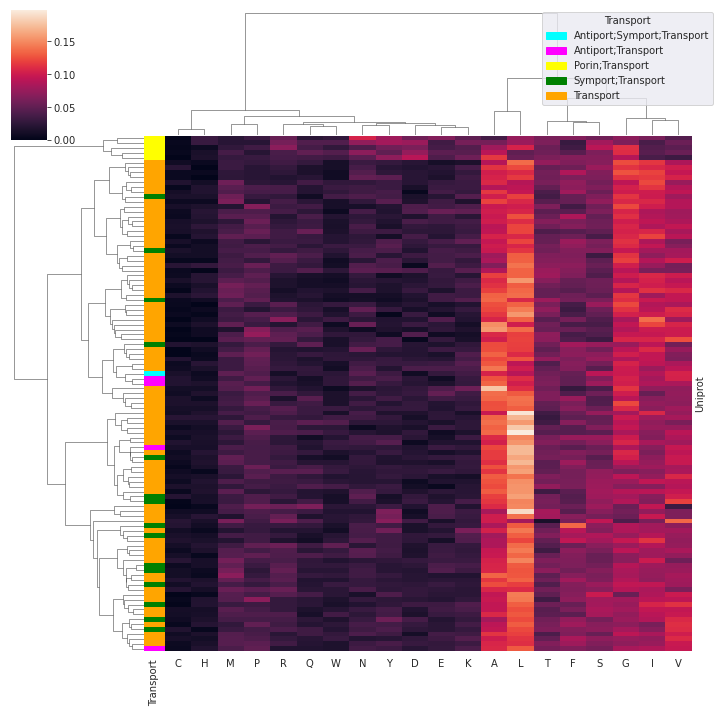

In [20]:
labeled_clustermap(df_aac, df.keywords_transport_related.rename("Transport"), xlabels="auto")

({'Amino-acid transport': 'cyan',
  'Amino-acid transport;Ion transport;Sodium transport': 'magenta',
  'Ion transport;Polysaccharide transport;Sugar transport': 'yellow',
  'Ion transport;Sugar transport': 'green',
  'Phosphate transport;Sugar transport': 'orange',
  'Sugar transport': 'red'},
 <seaborn.matrix.ClusterGrid at 0x7f5bbd803730>)

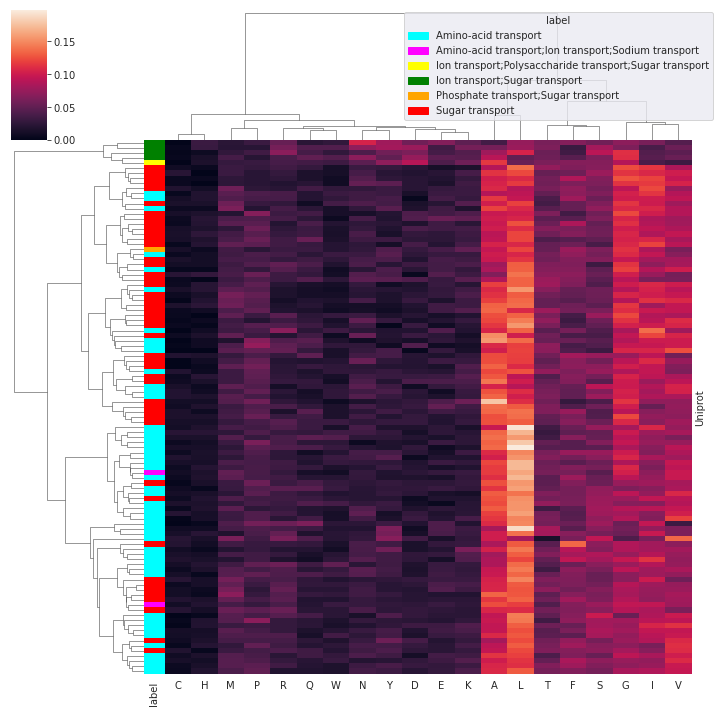

In [21]:
labeled_clustermap(df_aac, labels, xlabels="auto")

The classes are not clearly separable using two PCs, but a pattern seems to be a higher PC2 value for AA transporters, on average.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

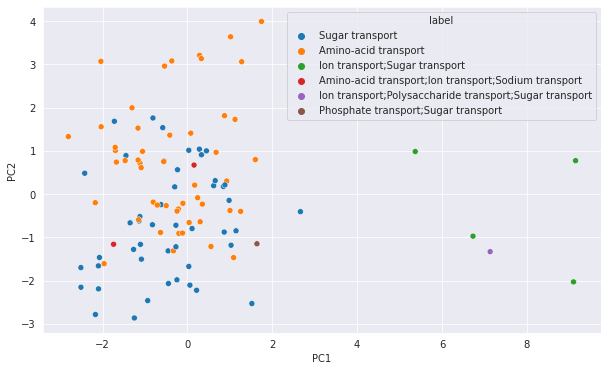

In [22]:
pca_plot_2d(df_aac, labels)

### PAAC plot

The paac feature contains a small subset of frequently occuring dipeptides, this time even less than for A thaliana.

({'Amino-acid transport': 'cyan',
  'Amino-acid transport;Ion transport;Sodium transport': 'magenta',
  'Ion transport;Polysaccharide transport;Sugar transport': 'yellow',
  'Ion transport;Sugar transport': 'green',
  'Phosphate transport;Sugar transport': 'orange',
  'Sugar transport': 'red'},
 <seaborn.matrix.ClusterGrid at 0x7f5bd24aa1c0>)

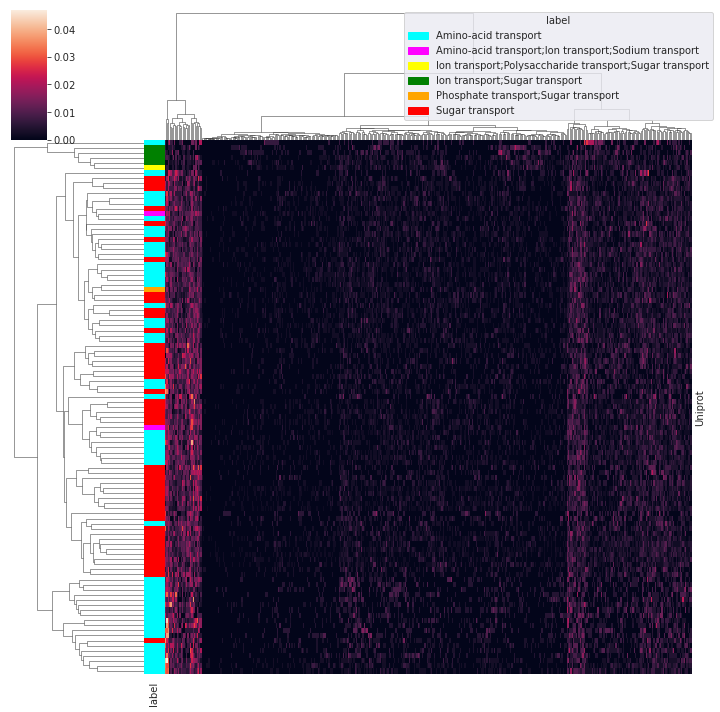

In [23]:
labeled_clustermap(df_paac, labels)

Unsurprisingly, this cluster is made up of hydrophobic amino acids, and helix residues such as Gly:

In [24]:
# cluster1 is the smaller one.
cluster0, cluster1 = get_clusters(df_paac.T, n_clusters=2)
print(len(cluster1))
print(cluster1)
from collections import Counter
counter = Counter()
for dipeptide in cluster1:
    counter[dipeptide[0]] +=1
    counter[dipeptide[1]] +=1
counter

28
['AA', 'AG', 'AI', 'AL', 'AV', 'GA', 'GG', 'GI', 'GL', 'GV', 'IA', 'IG', 'II', 'IL', 'IV', 'LA', 'LF', 'LG', 'LI', 'LL', 'LS', 'LV', 'SL', 'TL', 'VA', 'VG', 'VI', 'VL']


Counter({'A': 10, 'G': 10, 'I': 10, 'L': 14, 'V': 8, 'F': 1, 'S': 2, 'T': 1})

## Feature plots



#### Correlation

There do not seem to be any features that show a high correlation across all classes:

<AxesSubplot:>

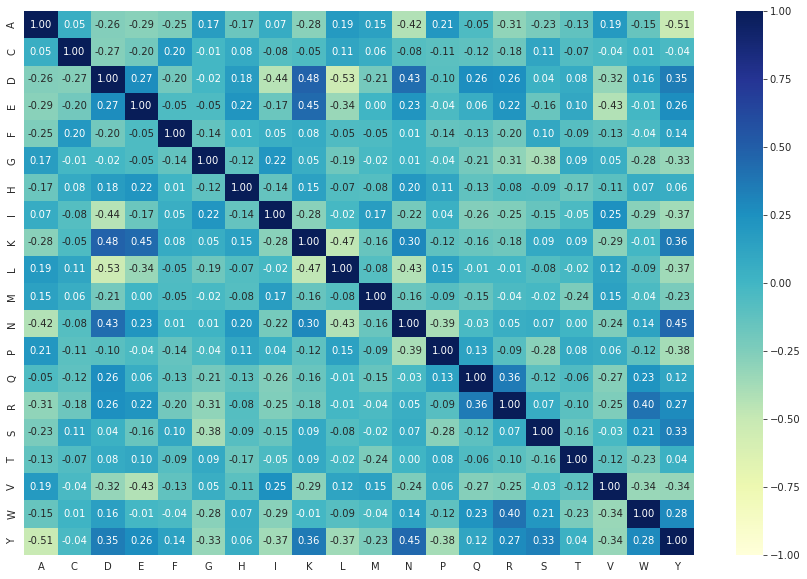

In [27]:
corr_heatmap(df_aac)

<AxesSubplot:>

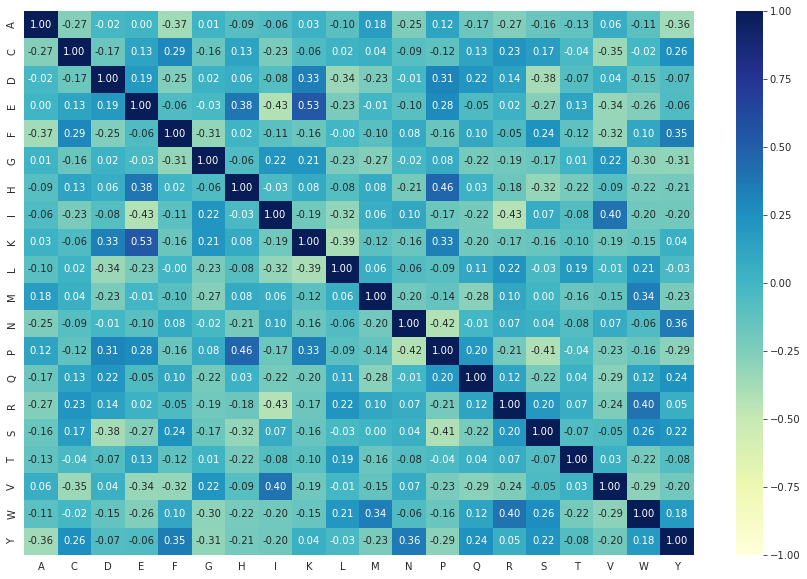

In [26]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Sugar transport"].index])

<AxesSubplot:>

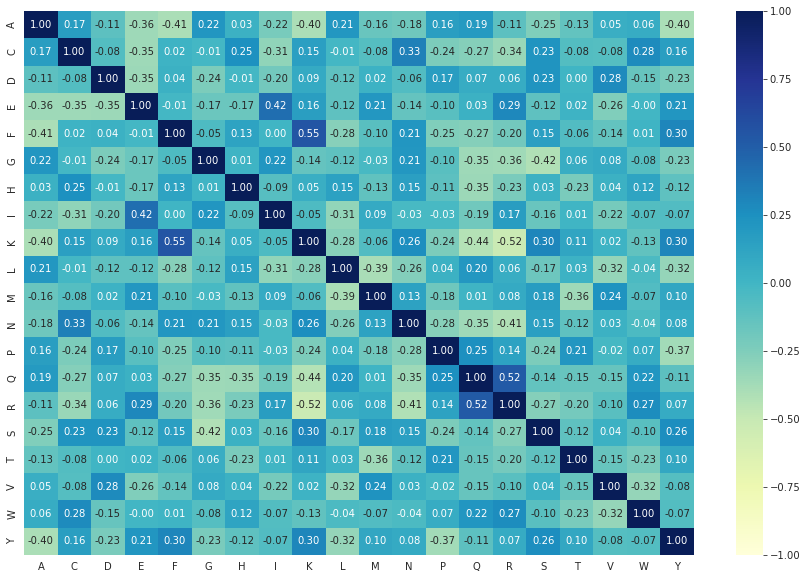

In [28]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Amino-acid transport"].index])

#### Distribution

According to shapiro-wilk, most features follow a normal distribution. There is a slight deviation for E and P.

<AxesSubplot:>

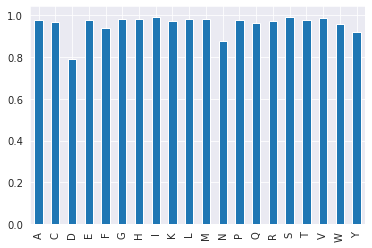

In [30]:
from scipy.stats import shapiro

df_aac.apply(shapiro).loc[0].plot.bar()

##### High Proline

There are five outliers that lead to high proline:

<AxesSubplot:ylabel='Frequency'>

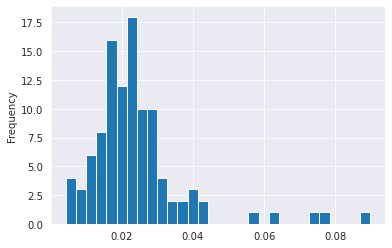

In [31]:
df_aac.D.plot.hist(bins=30)

 Upon further inspection, they are the porins again:

In [32]:
df.loc[df_aac[df_aac.D > 0.05].index].join(df_aac.P, how="left").drop("sequence", axis=1)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,P
Uniprot,,,,,,,,,
P76773,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,ompL yshA b3875 JW3846,Porin OmpL,1.B.35.2.2,1.B,83333,0.030435
Q47706,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,uidC gusC b1615 JW1607,Membrane-associated protein UidC,1.B.25.1.5,1.B,83333,0.033254
P02943,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,lamB malB b4036 JW3996,Maltoporin (Maltose outer membrane channel) (M...,1.B.3.1.1,1.B,83333,0.020179
P75733,Ion transport;Polysaccharide transport;Sugar t...,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,chiP ybfM b0681 JW0667,Chitoporin (ChiP-III),1.B.25.1.13,1.B,83333,0.029915
P69856,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,nanC yjhA b4311 JW5778,Probable N-acetylneuraminic acid outer membran...,1.B.35.2.1,1.B,83333,0.021008


##### High Asp

There seem to be more outliers for glutamate

<AxesSubplot:ylabel='Frequency'>

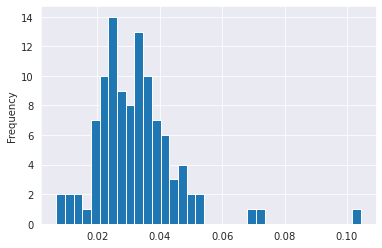

In [33]:
df_aac.N.plot.hist(bins=35)

That is also the case for Asp:

In [34]:
df.loc[df_aac[df_aac.N > 0.065].index].join(df_aac.E, how="left").drop("sequence", axis=1)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,E
Uniprot,,,,,,,,,
P76773,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,ompL yshA b3875 JW3846,Porin OmpL,1.B.35.2.2,1.B,83333,0.065217
P02943,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,lamB malB b4036 JW3996,Maltoporin (Maltose outer membrane channel) (M...,1.B.3.1.1,1.B,83333,0.047085
P69856,Ion transport;Sugar transport,Cell outer membrane;Membrane;Transmembrane,Porin;Transport,nanC yjhA b4311 JW5778,Probable N-acetylneuraminic acid outer membran...,1.B.35.2.1,1.B,83333,0.033613
